## Nitrate for the 201905R

In [70]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [71]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [72]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [73]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [74]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [75]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [76]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [77]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [78]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [79]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, ab):
    vmax = 36
    vmin = 0
#    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color, ax=ax)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'NO3', 'mod_nitrate')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tspread = spread(temp1[temp1.k >= idepth], 'NO3', 'mod_nitrate')
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(5, 30, 0, 2-np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 34, 0, -2+np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 30, 0, 2-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 34, 0, -2+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 29, 0, 3-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 35, 0, -3+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(5-0.6, 26, 'bias', rotation=90)
    ax.text(7-0.6, 22, 'systematic', rotation=90)
    ax.text(9-0.6, 19, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Nitrate {ab}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [80]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [81]:
def do_three_across(year, pieces):
    temp1 = read_pieces(pieces)
    temp1['NO3'] = temp1.N
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    idepth = 19
    jdepth = 39
    b2007 = plot_and_stats(temp1, f'b{year}', idepth, jdepth, fig, axs[0], 'below 20 m')
    b2007.style.format(myformat)
    idepth = 0
    jdepth = 18
    a2007 = plot_and_stats(temp1, f'a{year}', idepth, jdepth, fig, axs[1], 'above 20 m')
    a2007.style.format(myformat)
    idepth = 0
    jdepth = 39
    t2007 = plot_and_stats(temp1, f't{year}', idepth, jdepth, fig, axs[2], 'all depths')
    t2007.style.format(myformat)
    return b2007, a2007, t2007

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2007,827,-0.77,2.9,0.2,0.41,1.1e+01,1.7,2.4,0.25
a2007,233,-0.73,4.3,0.091,0.22,3.8,1.9,3.9,0.14
t2007,1060,-0.76,3.3,0.091,0.22,4.9,1.5,2.9,0.14


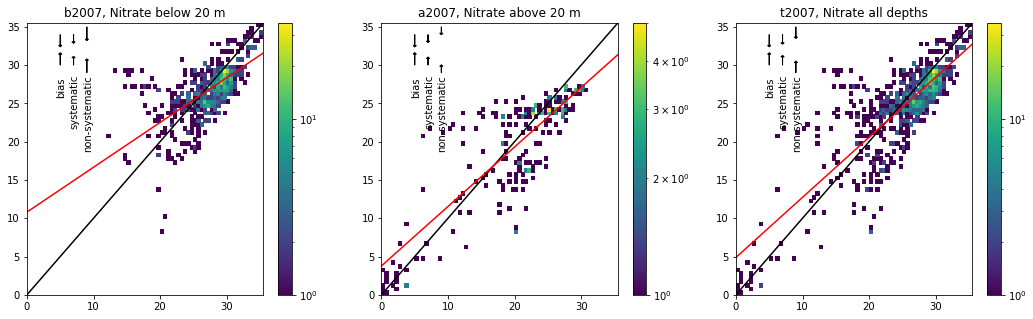

In [82]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20070101_20071231.csv'
         )
b2007, a2007, t2007 = do_three_across(2007, [pieces])
alltogether = pd.concat([b2007, a2007, t2007], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2008,788,-0.54,2.7,0.15,0.34,9.1,1.4,2.3,0.19
a2008,308,-0.95,6.2,0.087,0.36,5.6,3.3,5.3,0.083
t2008,1096,-0.66,4.0,0.087,0.2,4.4,1.6,3.7,0.083


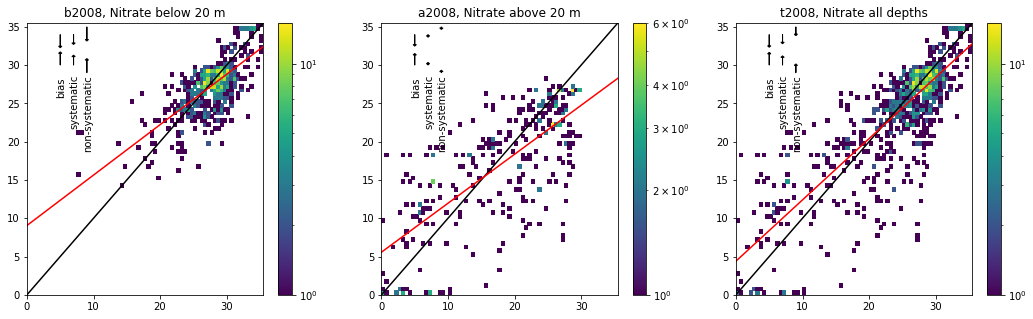

In [83]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20080101_20081231.csv'
         )
b2008, a2008, t2008 = do_three_across(2008, [pieces])
alltogether = pd.concat([b2008, a2008, t2008], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2009,818,-0.15,2.3,0.13,0.38,1e+01,1.4,1.8,0.36
a2009,278,0.9,5.7,0.075,0.33,6.6,3.0,4.9,0.24
t2009,1096,0.11,3.5,0.075,0.25,6.3,1.7,3.1,0.24


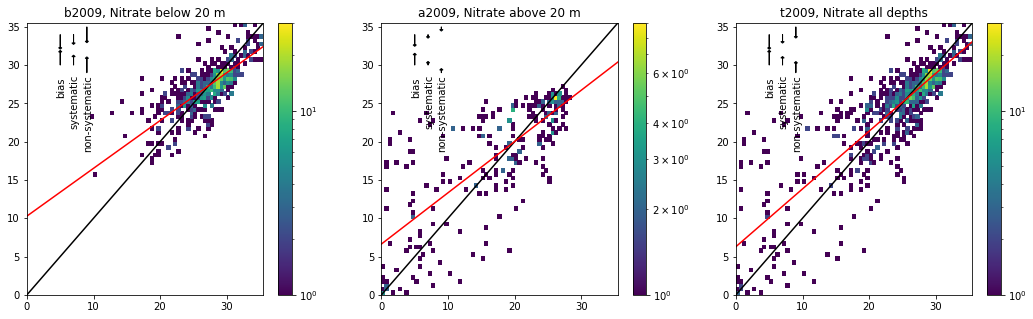

In [84]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20090101_20091231.csv'
         )
b2009, a2009, t2009 = do_three_across(2009, [pieces])
alltogether = pd.concat([b2009, a2009, t2009], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2010,1071,-0.79,2.4,0.11,0.33,8.5,1.6,1.8,0.48
a2010,390,0.72,5.2,0.054,0.31,5.4,2.8,4.3,0.34
t2010,1461,-0.39,3.4,0.054,0.22,5.1,1.8,2.9,0.34


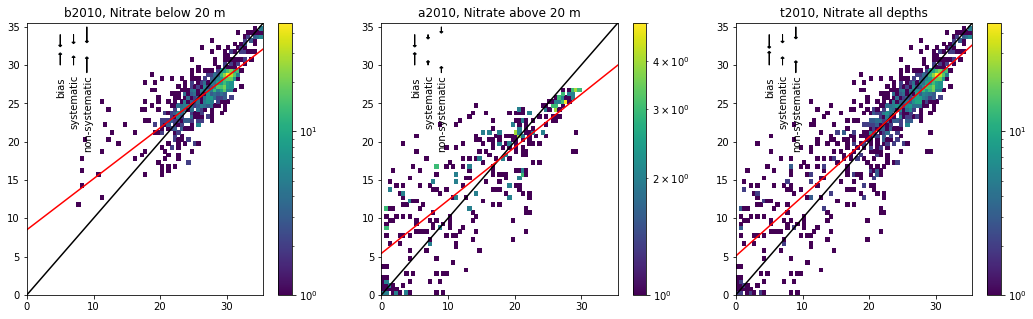

In [85]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20100101_20101231.csv'
         )
b2010, a2010, t2010 = do_three_across(2010, [pieces])
alltogether = pd.concat([b2010, a2010, t2010], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2011,896,-0.47,2.6,0.14,0.31,8.1,1.3,2.3,0.18
a2011,449,1.2,7.0,0.099,0.33,6.7,3.2,6.2,0.13
t2011,1345,0.087,4.6,0.099,0.25,6.1,2.0,4.1,0.13


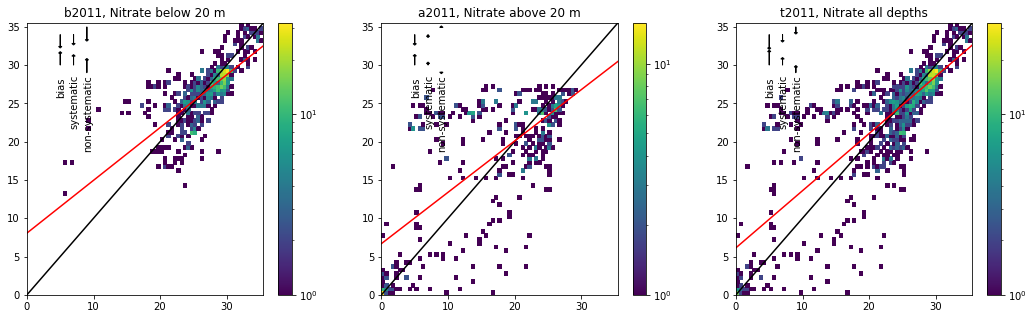

In [86]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20110101_20111231.csv'
         )
b2011, a2011, t2011 = do_three_across(2011, [pieces])
alltogether = pd.concat([b2011, a2011, t2011], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2012,929,-0.65,2.3,0.12,0.39,9.9,1.6,1.6,0.48
a2012,476,0.25,5.2,0.056,0.18,3.3,1.7,4.9,0.12
t2012,1405,-0.35,3.6,0.056,0.18,3.8,1.5,3.2,0.12


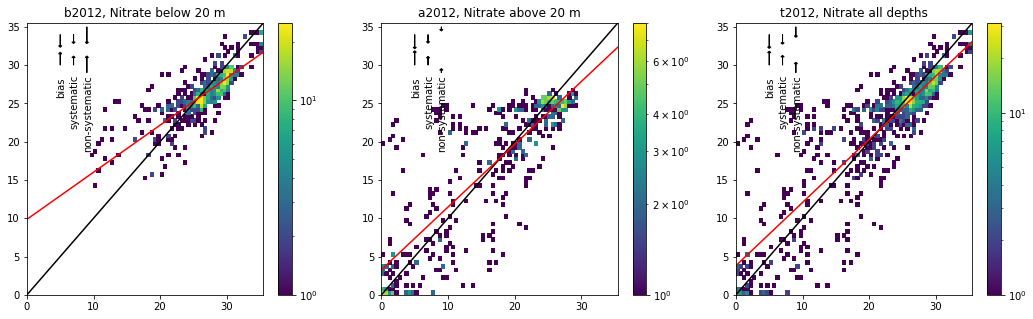

In [87]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20120101_20121231.csv'
         )
b2012, a2012, t2012 = do_three_across(2012, [pieces])
alltogether = pd.concat([b2012, a2012, t2012], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2013,671,-2.2,3.2,0.25,0.36,7.9,2.5,2.0,0.24
a2013,321,-0.93,5.6,0.081,0.37,5.3,3.3,4.4,0.25
t2013,992,-1.8,4.1,0.081,0.24,4.2,2.6,3.2,0.25


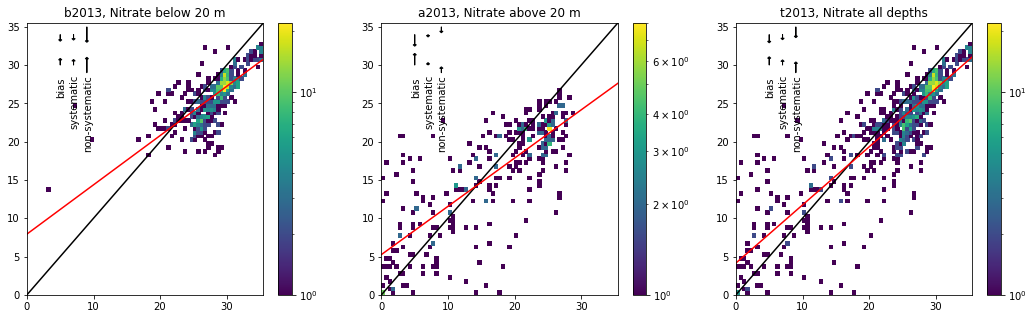

In [88]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20130101_20131231.csv'
         )
b2013, a2013, t2013 = do_three_across(2013, [pieces])
alltogether = pd.concat([b2013, a2013, t2013], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2013R,671,-2.6,3.4,0.26,0.34,7.2,2.8,1.9,0.26
b2013,671,-2.2,3.2,0.25,0.36,7.9,2.5,2.0,0.24
a2013R,321,-1.2,5.5,0.084,0.38,5.1,3.5,4.2,0.28
a2013,321,-0.93,5.6,0.081,0.37,5.3,3.3,4.4,0.25
t2013R,992,-2.1,4.2,0.084,0.25,3.9,2.9,3.0,0.28
t2013,992,-1.8,4.1,0.081,0.24,4.2,2.6,3.2,0.25


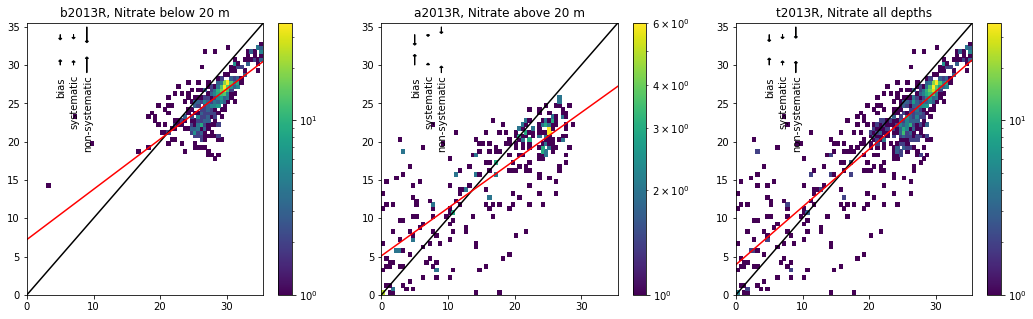

In [107]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20130101_20131231.csv'
         )
b2013R, a2013R, t2013R = do_three_across('2013R', [pieces])
alltogether = pd.concat([b2013R, b2013, a2013R, a2013, t2013R, t2013], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2014,1054,-2.7,3.5,0.16,0.29,5.6,3.0,1.7,0.36
a2014,438,-2.9,6.3,0.079,0.33,2.3,4.2,4.7,0.14
t2014,1492,-2.8,4.5,0.079,0.16,1.3,3.1,3.2,0.14


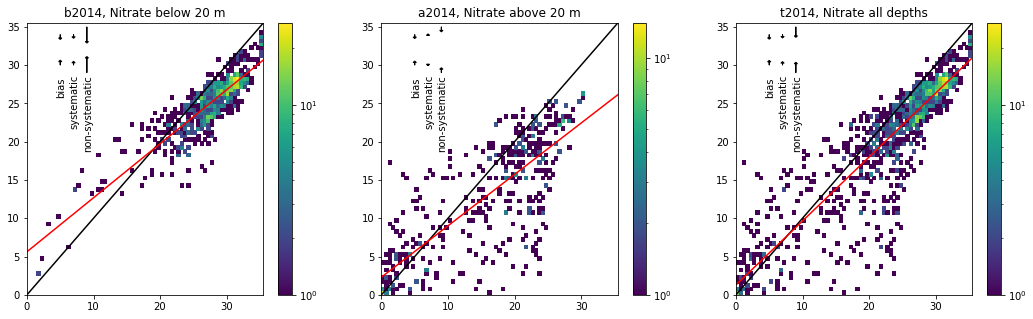

In [94]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20140101_20141231.csv'
         )
b2014, a2014, t2014 = do_three_across(2014, [pieces])
alltogether = pd.concat([b2014, a2014, t2014], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2014R,1054,-2.9,3.6,0.17,0.29,5.2,3.2,1.7,0.35
b2014,1054,-2.7,3.5,0.16,0.29,5.6,3.0,1.7,0.36
a2014R,438,-2.5,5.7,0.075,0.32,2.6,3.8,4.3,0.2
a2014,438,-2.9,6.3,0.079,0.33,2.3,4.2,4.7,0.14
t2014R,1492,-2.8,4.3,0.075,0.18,1.7,3.2,3.0,0.2
t2014,1492,-2.8,4.5,0.079,0.16,1.3,3.1,3.2,0.14


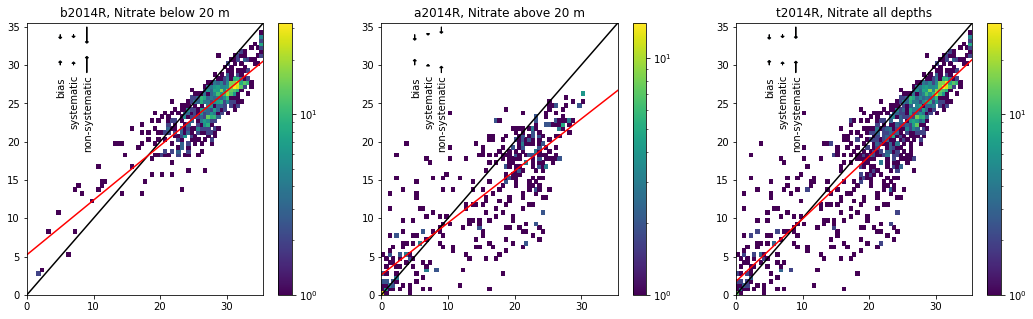

In [112]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20140101_20141231.csv'
         )
b2014R, a2014R, t2014R = do_three_across('2014R', [pieces])
alltogether = pd.concat([b2014R, b2014, a2014R, a2014, t2014R, t2014], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2015,392,-2.0,2.8,0.21,0.34,6.9,2.2,1.6,0.29
a2015,141,-0.47,4.9,0.065,0.25,3.1,2.0,4.5,0.22
t2015,533,-1.6,3.5,0.065,0.19,2.8,2.1,2.8,0.22


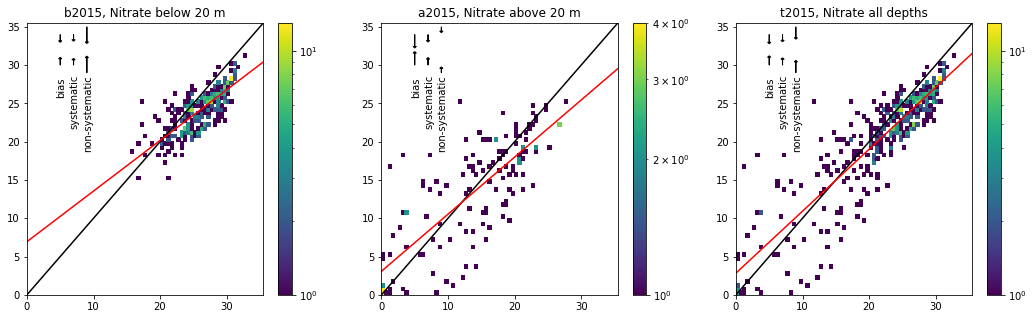

In [100]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20150101_20151231.csv'
         )
b2015, a2015, t2015 = do_three_across(2015, [pieces])
alltogether = pd.concat([b2015, a2015, t2015], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2015R,392,-2.1,2.9,0.23,0.35,7.2,2.4,1.7,0.29
b2015,392,-2.0,2.8,0.21,0.34,6.9,2.2,1.6,0.29
a2015R,141,-0.72,5.0,0.069,0.26,2.9,2.1,4.6,0.21
a2015,141,-0.47,4.9,0.065,0.25,3.1,2.0,4.5,0.22
t2015R,533,-1.7,3.6,0.069,0.19,2.6,2.2,2.8,0.21
t2015,533,-1.6,3.5,0.065,0.19,2.8,2.1,2.8,0.22


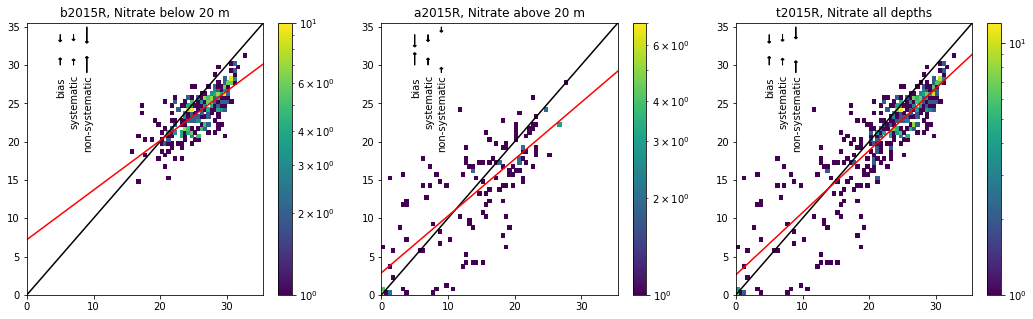

In [116]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20150101_20151231.csv'
         )
b2015R, a2015R, t2015R = do_three_across('2015R', [pieces])
alltogether = pd.concat([b2015R, b2015, a2015R, a2015, t2015R, t2015], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2016,1072,-1.5,2.4,0.088,0.16,2.9,1.6,1.7,0.14
a2016,601,-0.56,4.5,0.037,0.25,2.8,2.4,3.8,0.16
t2016,1673,-1.1,3.3,0.037,0.15,2.1,1.8,2.8,0.16


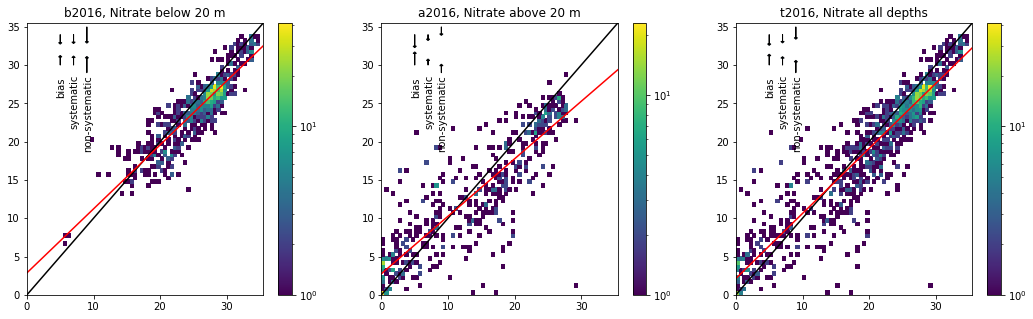

In [120]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20160101_20161231.csv'
         )
b2016, a2016, t2016 = do_three_across(2016, [pieces])
alltogether = pd.concat([b2016, a2016, t2016], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2016R,1072,-1.5,2.4,0.092,0.17,3.0,1.7,1.8,0.14
b2016,1072,-1.5,2.4,0.088,0.16,2.9,1.6,1.7,0.14
a2016R,601,-0.69,4.5,0.037,0.24,2.5,2.4,3.8,0.15
a2016,601,-0.56,4.5,0.037,0.25,2.8,2.4,3.8,0.16
t2016R,1673,-1.2,3.3,0.037,0.15,1.9,1.8,2.8,0.15
t2016,1673,-1.1,3.3,0.037,0.15,2.1,1.8,2.8,0.16


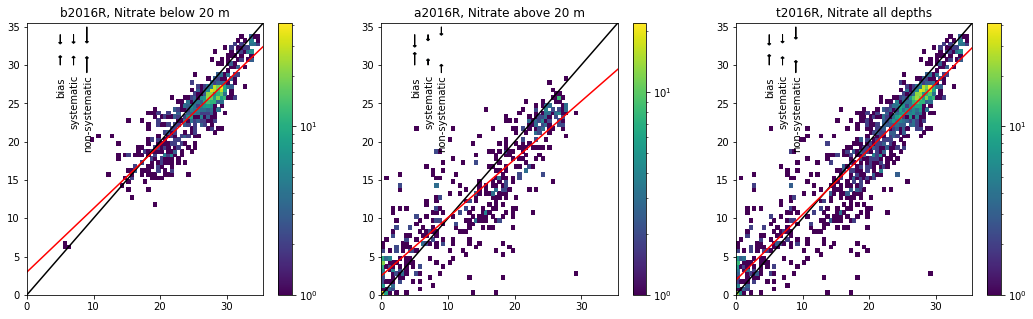

In [121]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20160101_20161231.csv'
         )
b2016R, a2016R, t2016R = do_three_across('2016R', [pieces])
alltogether = pd.concat([b2016R, b2016, a2016R, a2016, t2016R, t2016], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2017,965,-0.74,2.6,0.1,0.35,8.2,1.8,1.9,0.41
a2017,625,1.0,5.7,0.075,0.36,6.1,3.2,4.7,0.14
t2017,1590,-0.042,4.1,0.075,0.27,5.7,2.3,3.4,0.14


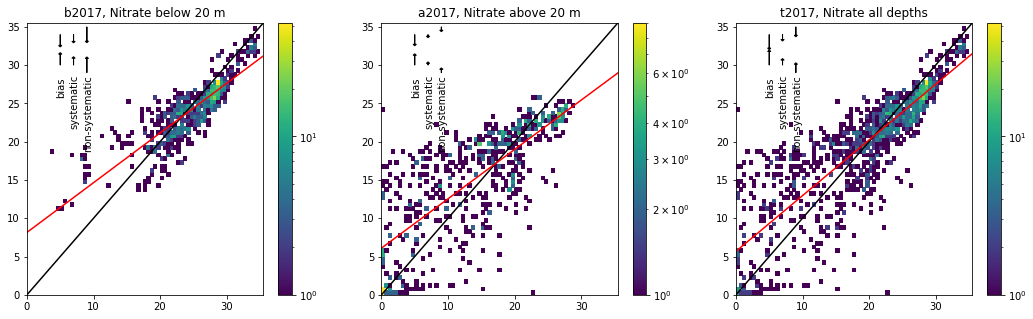

In [126]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20170101_20171231.csv'
         )
b2017, a2017, t2017 = do_three_across(2017, [pieces])
alltogether = pd.concat([b2017, a2017, t2017], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2017R,965,-0.75,2.6,0.11,0.36,8.2,1.8,1.9,0.42
b2017,965,-0.74,2.6,0.1,0.35,8.2,1.8,1.9,0.41
a2017R,625,0.77,5.6,0.072,0.36,5.8,3.1,4.6,0.13
a2017,625,1.0,5.7,0.075,0.36,6.1,3.2,4.7,0.14
t2017R,1590,-0.15,4.0,0.072,0.26,5.4,2.2,3.4,0.13
t2017,1590,-0.042,4.1,0.075,0.27,5.7,2.3,3.4,0.14


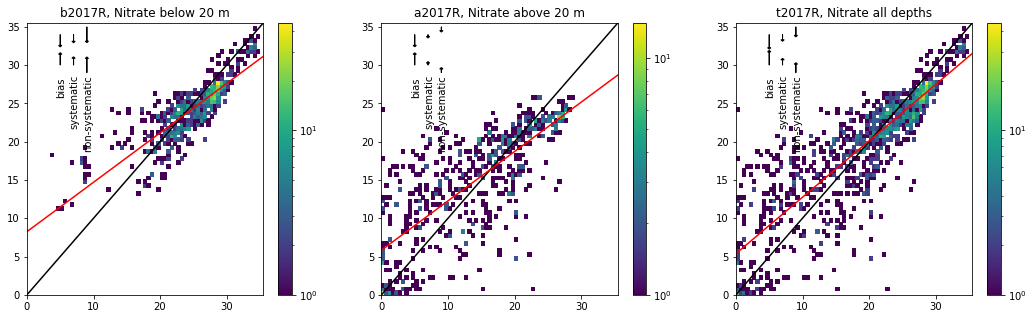

In [127]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20170101_20171231.csv'
         )
b2017R, a2017R, t2017R = do_three_across('2017R', [pieces])
alltogether = pd.concat([b2017R, b2017, a2017R, a2017, t2017R, t2017], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2018,1105,-1.1,2.2,0.14,0.26,6.0,1.3,1.7,0.04
a2018,571,-1.1,5.7,0.077,0.33,5.0,3.2,4.7,0.13
t2018,1676,-1.1,3.7,0.077,0.21,4.0,1.9,3.3,0.13


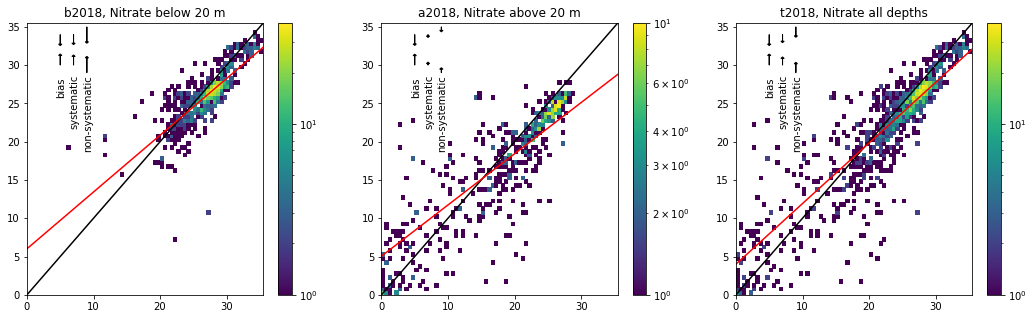

In [137]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20180101_20181231.csv'
         )
b2018, a2018, t2018 = do_three_across(2018, [pieces])
alltogether = pd.concat([b2018, a2018, t2018], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2018R,1105,-1.1,2.1,0.14,0.25,5.7,1.4,1.6,0.036
b2018,1105,-1.1,2.2,0.14,0.26,6.0,1.3,1.7,0.04
a2018R,571,-1.2,5.7,0.078,0.34,5.1,3.3,4.7,0.14
a2018,571,-1.1,5.7,0.077,0.33,5.0,3.2,4.7,0.13
t2018R,1676,-1.1,3.8,0.078,0.21,4.0,1.9,3.2,0.14
t2018,1676,-1.1,3.7,0.077,0.21,4.0,1.9,3.3,0.13


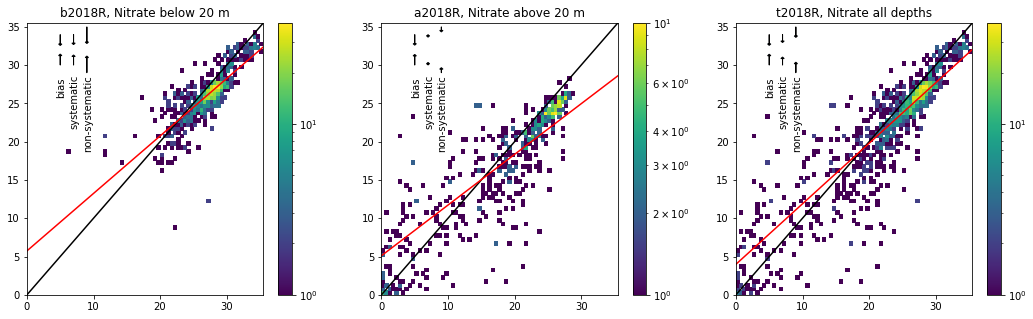

In [143]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20180101_20181231.csv'
         )
b2018R, a2018R, t2018R = do_three_across('2018R', [pieces])
alltogether = pd.concat([b2018R, b2018, a2018R, a2018, t2018R, t2018], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2019,886,-0.43,2.2,0.11,0.35,8.8,1.4,1.6,0.37
a2019,502,-0.18,4.5,0.051,0.23,3.7,2.0,4.0,0.059
t2019,1388,-0.34,3.2,0.051,0.18,3.7,1.4,2.9,0.059


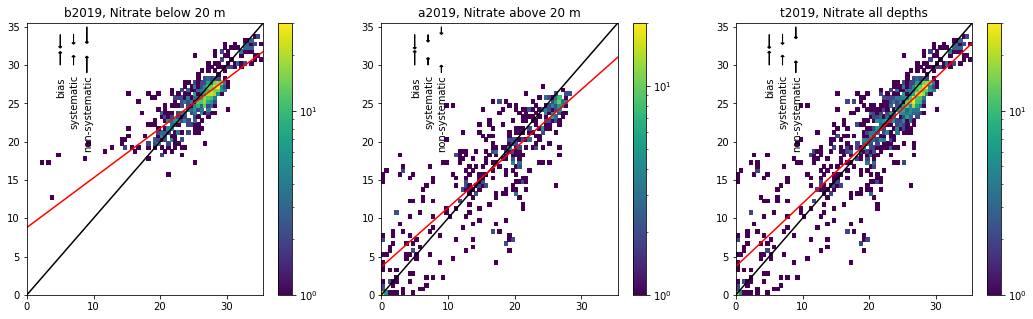

In [147]:
pieces = (
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20190101_20191231.csv'
         )
b2019, a2019, t2019 = do_three_across(2019, [pieces])
alltogether = pd.concat([b2019, a2019, t2019], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

In [148]:
alltogether = pd.concat([b2007, a2007, t2007,
                         b2008, a2008, t2008,
                         b2009, a2009, t2009,
                         b2010, a2010, t2010,
                         b2011, a2011, t2011,
                         b2012, a2012, t2012,
                         b2013, a2013, t2013,
                         b2014, a2014, t2014,
                         b2015, a2015, t2015,
                         b2016, a2016, t2016,
                         b2017, a2017, t2017,
                         b2018, a2018, t2018,
                         b2019, a2019, t2019], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
b2007,827,-0.77,2.9,0.2,0.41,1.1e+01,1.7,2.4,0.25
a2007,233,-0.73,4.3,0.091,0.22,3.8,1.9,3.9,0.14
t2007,1060,-0.76,3.3,0.091,0.22,4.9,1.5,2.9,0.14
b2008,788,-0.54,2.7,0.15,0.34,9.1,1.4,2.3,0.19
a2008,308,-0.95,6.2,0.087,0.36,5.6,3.3,5.3,0.083
t2008,1096,-0.66,4.0,0.087,0.2,4.4,1.6,3.7,0.083
b2009,818,-0.15,2.3,0.13,0.38,1e+01,1.4,1.8,0.36
a2009,278,0.9,5.7,0.075,0.33,6.6,3.0,4.9,0.24
t2009,1096,0.11,3.5,0.075,0.25,6.3,1.7,3.1,0.24
b2010,1071,-0.79,2.4,0.11,0.33,8.5,1.6,1.8,0.48


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
ball,11474,-1.0,2.6,0.13,0.32,7.6,1.6,2.0,0.29
aall,5333,-0.25,5.5,0.066,0.29,4.5,2.6,4.8,0.15
tall,16807,-0.8,3.8,0.066,0.2,4.0,1.8,3.3,0.15


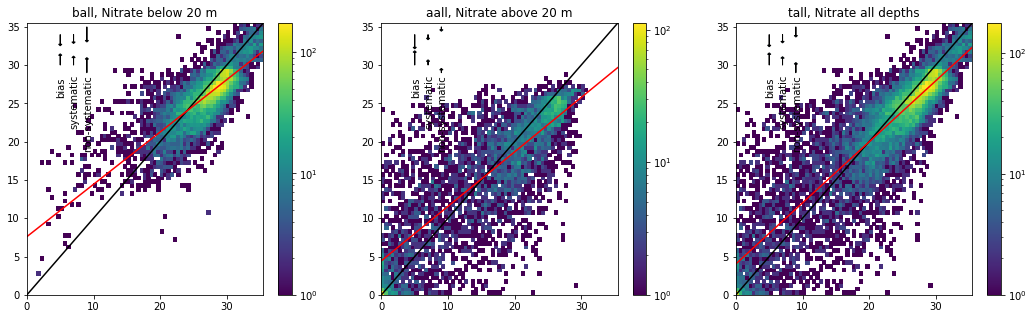

In [149]:
pieces = ('/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20070101_20071231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20080101_20081231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20090101_20091231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20100101_20101231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20110101_20111231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20120101_20121231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20130101_20131231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20140101_20141231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20150101_20151231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20160101_20161231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20170101_20171231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905W_bot_20180101_20181231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_bot_20190101_20191231.csv',
         )
below, above, total = do_three_across('all', pieces)
alltogether = pd.concat([below, above, total], axis=0)
alltogether.style.format(myformat).apply(highlight_max_min)          

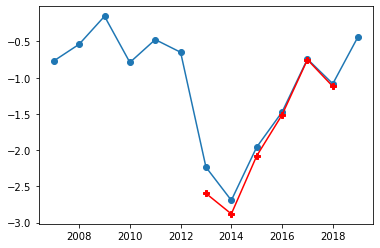

In [150]:
plt.plot([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
         [b2007.bias, b2008.bias, b2009.bias, b2010.bias, b2011.bias, b2012.bias, b2013.bias, b2014.bias, b2015.bias, b2016.bias, b2017.bias, b2018.bias,
         b2019.bias], 'o-');
plt.plot([2013, 2014, 2015, 2016, 2017, 2018], [b2013R.bias, b2014R.bias, b2015R.bias, b2016R.bias, b2017R.bias, b2018R.bias], 'rP-');

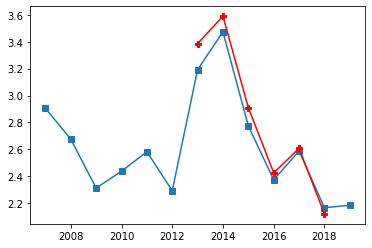

In [151]:
plt.plot([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
         [b2007.rmse, b2008.rmse, b2009.rmse, b2010.rmse, b2011.rmse, b2012.rmse, b2013.rmse, b2014.rmse, b2015.rmse, b2016.rmse, b2017.rmse, b2018.rmse,
         b2019.rmse], 's-');
plt.plot([2013, 2014, 2015, 2016, 2017, 2018], [b2013R.rmse, b2014R.rmse, b2015R.rmse, b2016R.rmse, b2017R.rmse, b2018R.rmse], 'rP-');

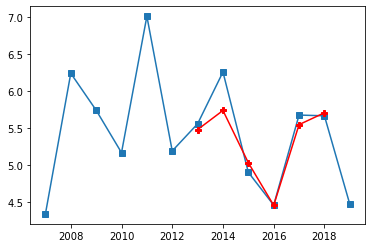

In [152]:
plt.plot([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
         [a2007.rmse, a2008.rmse, a2009.rmse, a2010.rmse, a2011.rmse, a2012.rmse, a2013.rmse, a2014.rmse, a2015.rmse, a2016.rmse, a2017.rmse, a2018.rmse,
         a2019.rmse], 's-');
plt.plot([2013, 2014, 2015, 2016, 2017, 2018], [a2013R.rmse, a2014R.rmse, a2015R.rmse, a2016R.rmse, a2017R.rmse, a2018R.rmse], 'rP-');